In [1]:
import numpy as np
from Common_function import *
import matplotlib.pyplot as plt
from itertools import product
import itertools
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import math
import random

x = 3  #how are is the distance set
Total_E_UGV = 500000 # in mah
Total_E_UAV = 15000 # in mah
UAV_E_cost = 1250 # in mah/km

UGV_E_cost_with_UAV = 1000 # in mah/km
UGV_E_cost_without_UAV = 800 # in mah/km
Charging_speed = 1000 # in mah/km
speed_uav =30 # km/h
speed_ugv =10 # km/h
ten_minets = 1 #how many 10 mins it take for survay 
survey_time = ten_minets/6
UAV_E_s_cost = 2500*ten_minets # mah/km
# print(UAV_E_s_cost)
# waypoints = [(20, 10), (24, 37), (36, 43), (8, 8), (0, 50), (30, 44), (28, 4), (32, 25)]
# # waypoints = [(20,10), (10,10),(15,30)]
# plan_output = "0 -> 1 -> 2 -> 0"
# plan_output = "0 -> 3 -> 4 -> 1 -> 5 -> 2 -> 7 -> 6 -> 0"
# waypoints = [(0,0),(10,10),(15,3),(20,12.5),(30,-2.5),(10,-5)] # 6 
# plan_output = "0 -> 5 -> 2 -> 4 -> 3 -> 1 -> 0"
# waypoints = [(0, 0),(11, 54),(4, 49),(69, 26),(12, 39),(25, 1),(17, 12),(38, 11),(28, 49),(52, 36),(36, 27),(56, 44),(22, 58)] #13
# plan_output = "0 -> 6 -> 4 -> 2 -> 1 -> 12 -> 8 -> 11 -> 3 -> 9 -> 10 -> 7 -> 5 -> 0"
# waypoints = [(8, 23), (31, 50), (46, 4), (50, 39), (3, 14)]
# plan_output = " 0 -> 4 -> 2 -> 3 -> 1 -> 0"
waypoints = [(0, 0),(54, 85),(8, 92),(25, 32),(71, 1),(6, 75),(21, 87),(35, 48),(13, 55),(75, 44),(91, 95),(62, 77),(53, 20),(79, 70),(40, 7)] # 15 
plan_output = "0 -> 14 -> 12 -> 4 -> 9 -> 13 -> 10 -> 11 -> 1 -> 6 -> 2 -> 5 -> 8 -> 7 -> 3 -> 0"
max_radius = ((Total_E_UAV - UAV_E_s_cost) / UAV_E_cost) / 2
radii = np.linspace(max_radius, 1.0, x)
ordered_points = [waypoints[int(node)] for node in plan_output.split() if node.isdigit()]
ordered_points.append(ordered_points[0])


In [2]:
class Node:
    def __init__(self, id, radius=None, total_time=None, level=0,end_point=None,E_UAV = None,E_UGV = None,visit_count = 0,max_childen=0):
        self.id = id
        self.radius = radius
        self.total_time = total_time
        self.level = level
        self.children = []
        self.E_UAV = E_UAV
        self.E_UGV = E_UGV
        self.visit_count = 0
        self.end_point = end_point
        self.value = 0.0  # For MCTS
        self.parent = None  # For MCTS
        self.max_childen = max_childen 
        self.expanded_children = 0
        
    def add_child(self, node):
        """Adds a child to the current node."""
        node.level = self.level + 1
        node.parent = self  # Set parent for MCTS
        self.children.append(node)
        
    def delete_child(self, node):
        """Removes a child from the current node."""
        if node in self.children:
            self.children.remove(node)

    

    def traverse(self):
        """Traverses and displays the tree starting from the current node."""
        # print(f"Node ID: {self.id}, Visits: {self.visit_count}, Value: {self.value}")
        print(f"Node ID: {self.id}, Radius: {self.radius}, Total Time: {self.total_time}, Level: {self.level}, E_UAV: {self.E_UAV}, E_UGV: {self.E_UGV}, Visits: {self.visit_count}, Value: {self.value},max_child: {self.max_childen}")
        for child in self.children:
            child.traverse()

    def get_nodes(self):
        """Returns all nodes in the tree starting from the current node."""
        nodes = [self]
        for child in self.children:
            nodes.extend(child.get_nodes())
        return nodes

    def ucb1(self, exploration_constant=4):
        """Calculates the UCB1 value for MCTS."""

        if self.visit_count == 0:
            # self.visit_count = 0.00001
            return float('inf')
        
        # Handling the root node
        if self.parent is None or self.parent.visit_count == 0:
            return self.value

        avg_value = self.value / self.visit_count

        exploration_term = exploration_constant * math.sqrt(2 * math.log(self.parent.visit_count) / self.visit_count)
        # print(self.parent.id, , self.visit_count,exploration_term)
        ucb1_value = avg_value + exploration_term
        
        return ucb1_value


    def fully_expanded(self,waypoints):
        """Checks if the node is fully expanded."""
        return self.level == len(waypoints)   # 

    def update(self, reward):
        """Updates the node's value and visit count based on the given reward."""
        self.visit_count += 1
        self.value += reward

    def select(self, waypoints):
        """Select a node (can be current or its child) based on the UCB1 scores."""
        current_node = self
        while current_node.children and not current_node.fully_expanded(waypoints):
            best_child = current_node.best_child()
            if best_child.ucb1() > current_node.ucb1():
                current_node = best_child
            else:
                break         
        return current_node



    def best_child(self):
        """Returns the child node with the highest UCB1 score."""
        return max(self.children, key=lambda node: node.ucb1(), default=None) # Max UCB1 is the best. 


In [3]:
def add_node_with_random_radius(parent, nodes_in_order,old_nodes_counter, r):
    # print(f"data_in nodes_in_order :{nodes_in_order}")
    waypoint_index = parent.level + 1
    
    # print(f"waypoint_index:{waypoint_index},with radius:{r}")
    if waypoint_index >= len(nodes_in_order):
        # print(f"0000000 {waypoint_index} > {len(nodes_in_order)} 00000000")
        return
    if waypoint_index == 1: # starting point, no charging need to be cal for the begining path
        
        radius_set, UGV_path, UAV_path, UAV_path_segment_distance,UGV_outer_path, UGVD_inter_without_drone, UGVD_inter_with_drone, final_wait_time= compute_path_for_one_point(ordered_points, waypoint_index, r, speed_ugv, speed_uav, survey_time)
        UGV_out_distance = compute_distance(ordered_points[0], UAV_path[0][0])
        UGV_inter_distance = compute_distance(UGV_path[0],UGV_path[1])
        UGV_distance = UGV_out_distance + UGV_inter_distance
        UAV_distances =UAV_path_segment_distance
        
        UGV_Trip_Cost = UGVD_inter_without_drone[0] * UGV_E_cost_without_UAV + UGV_out_distance * UGV_E_cost_with_UAV
        UAV_Trip_Cost = UAV_distances * UAV_E_cost + UAV_E_s_cost

        charging_distance = UGVD_inter_with_drone[0]
        
        UGV_energy_remaining = Total_E_UGV - UGV_Trip_Cost
        UAV_energy_remaining = Total_E_UAV - UAV_Trip_Cost
        if UGV_energy_remaining < 0 or UAV_energy_remaining < 0:
            print("1111111 UGV_energy_remaining Or  UAV_energy_remaining < 0 11111111111")
            parent.visit_count +=1
            return  None , old_nodes_counter # Indicating mission failed for both
        
        charging_distance = UGVD_inter_with_drone[0]
        if UAV_energy_remaining < Total_E_UAV:
            charge_amount = min(Charging_speed * charging_distance , UAV_Trip_Cost, UGV_energy_remaining)
            UGV_energy_remaining -= charge_amount
            UAV_energy_remaining += charge_amount
            
        if UGV_energy_remaining < 0 or UAV_energy_remaining < 0:
            parent.visit_count +=1
            return  None , old_nodes_counter # Indicating mission failed for both
        else:
            pass_flag = 0
        total_time = parent.total_time  + final_wait_time +UGV_distance / speed_ugv

    elif waypoint_index == (len(nodes_in_order) -1): # Ending point, don't charge the drone on the wayback
        
        UAV_path = []
        final_wait_time = 0
        UGV_path = [parent.end_point,ordered_points[-1]]
        UGV_distance = compute_distance(parent.end_point,ordered_points[-1])
        total_time = parent.total_time + UGV_distance / speed_ugv 

        UGV_energy_remaining =parent.E_UGV
        UAV_energy_remaining =parent.E_UAV
        
        UGV_Trip_Cost = UGV_distance * UGV_E_cost_with_UAV
        UAV_Trip_Cost = 0
        UGV_energy_remaining -= UGV_Trip_Cost
        if UGV_energy_remaining < 0:
            parent.visit_count +=1
            return  None , old_nodes_counter # Indicating mission failed for both
        else:
            pass_flag = 2
        
    else: #Any Mid point on the way 
        
        radius_set, UGV_path, UAV_path, UAV_path_segment_distance,UGV_outer_path, UGVD_inter_without_drone, UGVD_inter_with_drone, final_wait_time= compute_path_for_one_point(ordered_points, waypoint_index, r, speed_ugv, speed_uav, survey_time)
        UGV_inter_distance = compute_distance(UGV_path[0],UGV_path[1])
        # print(f"parent.end_point:{parent.end_point}")
        UGV_out_distance = compute_distance(parent.end_point,UGV_path[0])

        UGV_distance = UGV_out_distance + UGV_inter_distance

        UAV_distances =UAV_path_segment_distance
        
        UGV_Trip_Cost = UGVD_inter_without_drone[0] * UGV_E_cost_without_UAV + UGV_out_distance * UGV_E_cost_with_UAV
        UAV_Trip_Cost = UAV_distances * UAV_E_cost + UAV_E_s_cost
        
        UAV_energy_remaining = parent.E_UAV
        UGV_energy_remaining = parent.E_UGV
        
        charging_distance = UGV_out_distance
        if UAV_energy_remaining < Total_E_UAV:
            charge_amount = min(Charging_speed * charging_distance , (Total_E_UAV - UAV_energy_remaining), UGV_energy_remaining)
            UGV_energy_remaining -= charge_amount
            UAV_energy_remaining += charge_amount
            
        
        UGV_energy_remaining = UGV_energy_remaining - UGV_Trip_Cost
        UAV_energy_remaining = UAV_energy_remaining - UAV_Trip_Cost
        
        charging_distance = UGVD_inter_with_drone[0]
        if UAV_energy_remaining < Total_E_UAV:
            charge_amount = min(Charging_speed * charging_distance , (Total_E_UAV - UAV_energy_remaining), UGV_energy_remaining)
            UGV_energy_remaining -= charge_amount
            UAV_energy_remaining += charge_amount
            
        
        if UGV_energy_remaining < 0 or UAV_energy_remaining < 0:
            parent.visit_count +=1
            return  None , old_nodes_counter # Indicating mission failed for both
        else: 
            pass_flag = 0   
            total_time = parent.total_time  + UGV_distance / speed_ugv + final_wait_time

        
        
    if pass_flag == 1:
        # print("2222222222222222")
        parent.visit_count +=1
        # parent.reward = 0 
        # print(f"No plan find, return None, {old_nodes_counter}")
        return None , old_nodes_counter
        
       
        
        
    if pass_flag == 2:
        node_counter = old_nodes_counter+1 
        child = Node(id=node_counter, radius=None, total_time=total_time)
        parent.add_child(child)
        child.E_UGV = UGV_energy_remaining
        child.E_UAV = UAV_energy_remaining
        child.visit_count +=1
        child.end_point = UGV_path[-1]  # Placeholder; replace with appropriate logic

        return  child , node_counter
    else:
        node_counter = old_nodes_counter+1  # Increment global node ID counter
        child = Node(id=node_counter, radius=r, total_time=total_time)
        parent.add_child(child)
        child.E_UGV = UGV_energy_remaining
        child.E_UAV = UAV_energy_remaining
        # child.visit_count +=1
        child.end_point = UGV_path[-1]  # Placeholder; replace with appropriate logic
        
        # print("444444444444444444444")
        # print(f" child id :{child.id},child level :{child.level}")
        return  child , node_counter
          
    
    
   

In [4]:
def simulate(node, waypoints):
    # If the node is at the fully expanded depth
    if node.fully_expanded(waypoints):
        # Return the negative value of total_time as the reward
        # print(f"Fully expaned,as we min the total_time, so we make the reward inv of total time * 100{pow(node.total_time,-1)*100}")
        return pow(node.total_time,-1)*100
    else:
        # For non-fully expanded nodes, return a default value or continue with a simplified simulation
        # print("not fully expaned, so reward = 0 ")
        return 0

# Adjusting the expand_mcts function to introduce randomness
def backpropagate(node, reward):
    while node:
        node.update(reward*node.level)
        # print(f"backpropagate reward :{reward},to node :{node.id}")
        node = node.parent

In [5]:
def attempt_expansion_for_node(node, n, shuffled_radii, waypoints, nodes_in_order):
    # Extract the radii that have already been used for the children of this node
    used_radii = [child.radius for child in node.children]

    while not node.fully_expanded(waypoints):
        used_radii = [child.radius for child in node.children]
        used_radii_set = set(used_radii)
        available_radii = [r for r in shuffled_radii if r not in used_radii_set]
        # print(f"picked node {node.id} to play out,it has {available_radii} available_radii")
        if node.level == len(waypoints) -1 and node.children:
            node.visit_count +=1
            # print("!!!!!!!!!!!!!!!!!!!!! second to last and has child already !!!!!!!!!!!!!!!!!!!!!")
            break
        if node.fully_expanded(waypoints):
            available_radii = []
            # print("Is fully exapned ")
            break
        if available_radii:
            r = random.choice(available_radii)
        else:
            break
        # Skip this radius if it's already been used for a child of this node
        if r in used_radii:
            # print(f"Node {node.id} has no more expansion with all of those radius used {used_radii}")
            continue
        
        # Try to expand the current node with the current radius
        # print(f"during the playout, choose random r: {r} ")
        child, new_n = add_node_with_random_radius(node, nodes_in_order, n, r)
        # new_n +=1
        used_radii.append(r)
        
        # If expansion was successful, move to the child node and update n
        if child is not None:
            
            # print(f"Which added a new nodes {child.id}")
            node.expanded_children +=1
            node = child
            n = new_n
            used_radii = []
            # Add this radius to the used_radii listif :
          
            if node.fully_expanded(waypoints) :
                # available_radii = None
                # print("Is fully exapned ")
                break
            # print(used_radii)
        else:
            # print(f"unable to expland as the return is None")
            break
    return n, node

In [6]:
def MCTS_v2(root, n,nodes_in_order, waypoints, iterations=15):
    # shuffled_radii = random.sample(sorted(radii), len(radii))
    picked_node_ids =[]
    for _ in range(iterations):
        # print("leaf_node")
        # root.traverse()
        # print("root")
        # Selection !!!! 
        shuffled_radii = random.sample(sorted(radii), len(radii))
        leaf_node = root.select(waypoints)
        # print(f"the ucb1 chose the {leaf_node.id} ")
      
        leaf_node.visit_count +=1
        if leaf_node.fully_expanded(waypoints):
            # print("at the end no more to expand")
            leaf_node.parent.max_childen = 1
            continue
        # leaf_node.traverse()
        # print(f"I chose a node {leaf_node.id} that have {len(leaf_node.children)} children, and the node should have :{leaf_node.max_childen} ")
        # If the selected node is None, continue to the next iteration
        if leaf_node is None:
            # print("passed")
            continue
        if leaf_node.level == len(waypoints) -1:
            
            # print("!!!!!!!!!!!!!!!!!!!!! second to last passed!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            continue
        # 2. Expansion
        if len(leaf_node.children) < leaf_node.max_childen:
            # print("expanding to the max_childen")

            # nodes_to_explore = [leaf_node]  # Start exploring from the selected leaf node
            
            # while nodes_to_explore:
            current_node = leaf_node  # Get the first node from the list
            
            shuffled_radii = [r for r in shuffled_radii if r not in [child.radius for child in current_node.children]] # selest form shuffled_radii if not in current_node.child 
            # print(f"!!!!!!!shuffled_radii:{shuffled_radii}!!!!!!!!!!!!!!")
            for r in shuffled_radii:
                child, new_n = add_node_with_random_radius(current_node, nodes_in_order, n, r)
                if child == None:
                    current_node.max_childen -=1
                    # print(f"can't expanded with radius {r}, so decress the max children flag to {current_node.max_childen} ")
                else:
                    child.max_childen = current_node.max_childen
                current_node.expanded_children +=1
                
                # print(f"N = {n}")
                n = new_n
    
        if not leaf_node.children or leaf_node is None:
            continue
    
           
        
        available_children = [child for child in leaf_node.children if child.id not in picked_node_ids]
        if not available_children:  # If no more children are left
            # Reset picked_node_ids or handle this scenario differently
            picked_node_ids = []
            available_children = leaf_node.children  # Reset available children
        node = random.choice(available_children)
        picked_node_ids.append(node.id)
        
        # print(f"picked node {node.id} to play out,it has {len(available_children)} available_children")
        # print(f"reward = :{simulate(node, waypoints)}")
        n,node = attempt_expansion_for_node(node, n, shuffled_radii, waypoints, nodes_in_order)


        # Backpropagate 
        if node.fully_expanded(waypoints):

            # print("backpropagate")
            reward = simulate(node, waypoints)
            backpropagate(node, reward)
    

    #     print("-----------end ---------\n")
    # print(f"picked_node_ids:{picked_node_ids}")
    
    return root.best_child()  # Return the best child of the root based on UCB1


In [7]:
nodes_in_order = plan_output.split()
nodes_in_order = [int(node) for node in nodes_in_order if node.isdigit()]


# print(best_node.id,best_node.best_child,)


In [8]:
root = Node(id=0, radius=None, total_time=0, visit_count=0, max_childen = len(radii),level = 0)
print(f"nodes_in_order :{nodes_in_order},waypoints:{waypoints}")

# node = root
n = 0

# draw_tree(root)

nodes_in_order :[0, 14, 12, 4, 9, 13, 10, 11, 1, 6, 2, 5, 8, 7, 3, 0],waypoints:[(0, 0), (54, 85), (8, 92), (25, 32), (71, 1), (6, 75), (21, 87), (35, 48), (13, 55), (75, 44), (91, 95), (62, 77), (53, 20), (79, 70), (40, 7)]


In [9]:
# import time
# import csv

# # Write the header of the CSV file just once
# with open('results.csv', 'w', newline='') as csvfile:
#     fieldnames = ['duration_mcts_v2', 'total_time']
#     writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
#     writer.writeheader()

# for i in range(100):
    # start_time = time.time()
#     root = Node(id=0, radius=None, total_time=0, visit_count=0, max_childen=len(radii), level=0)
#     best_node = MCTS_v2(root, n, nodes_in_order, waypoints, 10000)
#     end_time = time.time()
#     duration_mcts_v2 = end_time - start_time
#     print(f"MCTS_v2 took {duration_mcts_v2:.4f} seconds to execute.")
    
#     result = find_min_total_time_node_at_level(root,len(waypoints))
#     total_time = result['total_time']
    
#     # Open the CSV file in append mode to avoid overwriting
#     with open('results.csv', 'a', newline='') as csvfile:
#         fieldnames = ['duration_mcts_v2', 'total_time']
#         writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        
#         # Write the data
#         writer.writerow({'duration_mcts_v2': duration_mcts_v2, 'total_time': total_time})


In [10]:
root = Node(id=0, radius=None, total_time=0, visit_count=0, max_childen=len(radii), level=0)
best_node = MCTS_v2(root, n, nodes_in_order, waypoints, 10000)
result = find_min_total_time_node_at_level(root,len(waypoints))
total_time = result['total_time']
print(total_time)

37.29638130147922


In [11]:
# Given values
num_of_waypoints = len(waypoints)
num_of_radii = len(radii)

# Recalculating the total number of nodes (excluding root)
total_nodes = sum([num_of_radii ** i for i in range(1, num_of_waypoints + 1)])

# Including the root node
total_nodes += 1

total_nodes


21523360

In [12]:
# def print_best_child_ids(node):
    
#     # Base case: if the node has no children, return
#     if not node.children:
#         return
    
#     best_child_node = node.best_child()
#     if best_child_node:  # It's possible best_child() returns None
#         print(best_child_node.id)
#         print_best_child_ids(best_child_node)

# # Call the function starting from the root node
# print_best_child_ids(root)

In [13]:

# draw_tree(root)
result = find_min_total_time_node_at_level(root,len(waypoints))
print(f"--------------------------Best Result: {result}-------------------------------------")

--------------------------Best Result: {'id': 2796, 'value': 40.2183790399126, 'total_time': 37.29638130147922, 'radius comb': [None, 3.0, 5.0, 5.0, 1.0, 1.0, 3.0, 5.0, 5.0, 5.0, 5.0, 3.0, 5.0, 5.0, 5.0, None]}-------------------------------------


In [14]:
radius_list = [x for x in result['radius comb'] if x is not None]
total_time = result['total_time']
result_in = [radius_list,total_time]
result_in

[[3.0, 5.0, 5.0, 1.0, 1.0, 3.0, 5.0, 5.0, 5.0, 5.0, 3.0, 5.0, 5.0, 5.0],
 37.29638130147922]

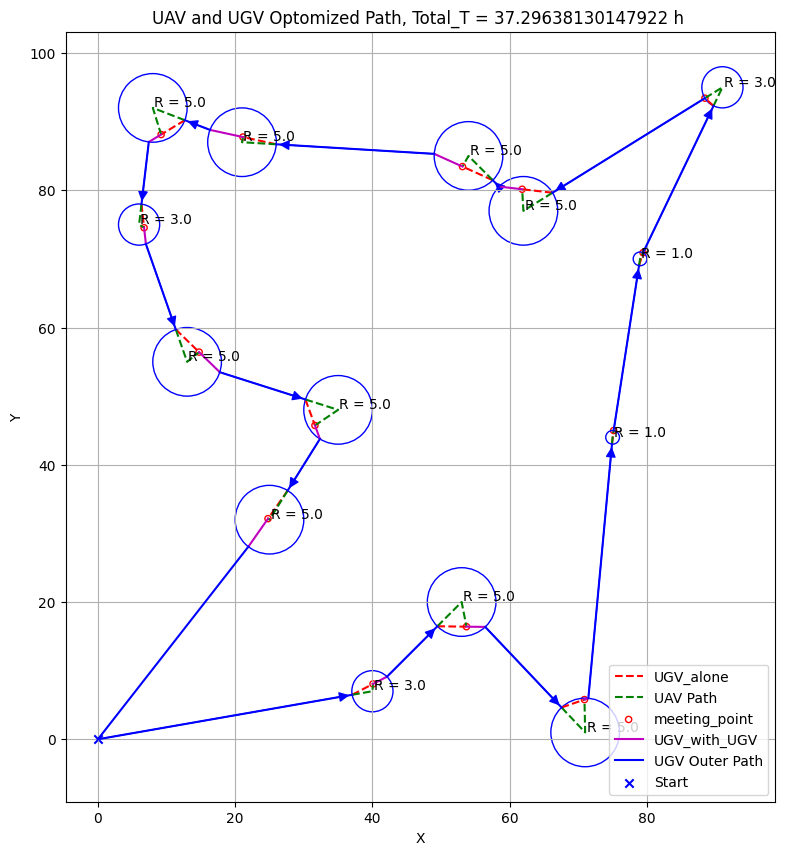

In [15]:
radius_set ,UGV_path, UAV_path, UGV_outer_path, UGVD_inter_without_drone, UGVD_inter_with_drone,final_wait_set= compute_optimized_paths_for_radius(ordered_points, radius_list, speed_ugv, speed_uav, survey_time)
plot_updated_paths_with_circles(UAV_path, UGV_outer_path, ordered_points, result_in)

In [16]:
# UGV_path, UAV_path, UGV_outer_path, UGVD_inter_without_drone,UGVD_inter_with_drone,final_wait_time= compute_optimized_paths_for_radius_updated_v5(ordered_points, radius_list, speed_ugv, speed_uav, survey_time)
